In [75]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

% matplotlib inline

# Exploratory Analysis

In [76]:
dateparse = lambda dates: pd.to_datetime(dates, format='%m/%d/%Y %I:%M:%S %p', errors='coerce').date

df = pd.read_csv('311_cases.csv', 
                 parse_dates=['Opened'], 
                 date_parser=dateparse)

In [77]:
df.shape

(494527, 20)

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494527 entries, 0 to 494526
Data columns (total 20 columns):
CaseID                 494527 non-null int64
Opened                 494527 non-null datetime64[ns]
Closed                 494527 non-null object
Updated                494527 non-null object
Status                 494527 non-null object
Status Notes           340505 non-null object
Responsible Agency     494527 non-null object
Category               494527 non-null object
Request Type           494527 non-null object
Request Details        487685 non-null object
Address                494526 non-null object
Street                 473984 non-null object
Supervisor District    473985 non-null float64
Neighborhood           472949 non-null object
Police District        472725 non-null object
Latitude               494527 non-null float64
Longitude              494527 non-null float64
Point                  494527 non-null object
Source                 494527 non-null object
Media

In [ ]:
df.head()

In [79]:
df = df[['Opened', 'Category', 'Request Type', 'Responsible Agency', 'Status Notes', 'Neighborhood', 'Source']]
df = df[df.Opened.notnull()]
df['Status Notes'] = df['Status Notes'].astype('str').apply(lambda x: x.lower())

For starters - explore most frequent requests

Text(0,0.5,'Open Requests')

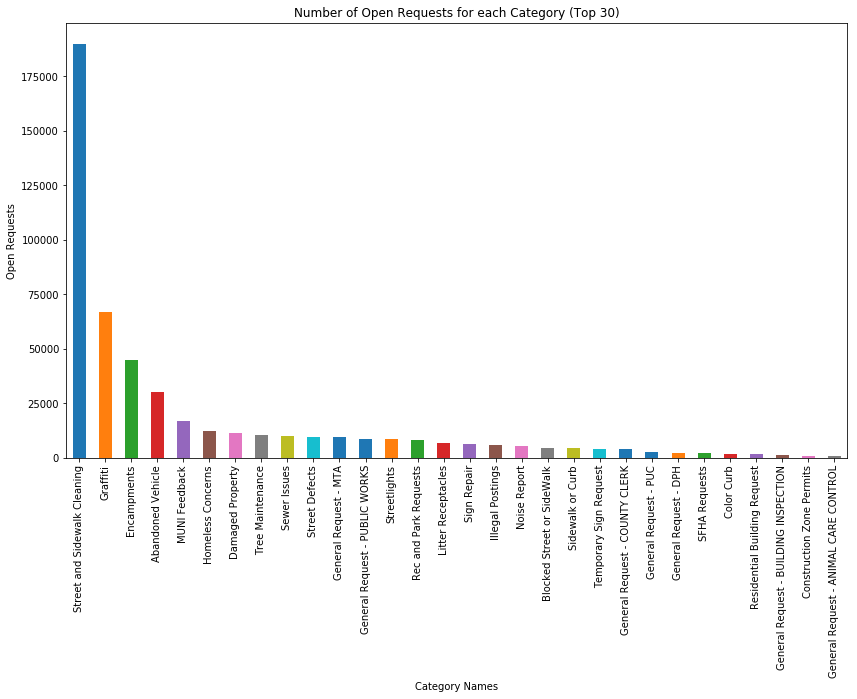

In [82]:
ax = df['Category'].value_counts()[:30].plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of Open Requests for each Category (Top 30)")
ax.set_xlabel("Category Names")
ax.set_ylabel("Open Requests")

In [83]:
categories_counts = df.groupby(by="Category").count()
categories_counts.sort_values(by='Opened', ascending=False)
occurrences_no = categories_counts[categories_counts.columns[0]].sort_values(ascending=False)[:30]

In [84]:
occurrences_no.head()

Category
Street and Sidewalk Cleaning    190055
Graffiti                         66982
Encampments                      45045
Abandoned Vehicle                29908
MUNI Feedback                    16960
Name: Opened, dtype: int64

In [ ]:
# confusion_matrix = pd.crosstab(df['Category'],df['Responsible Agency'])
# sns.heatmap(confusion_matrix, annot=True)

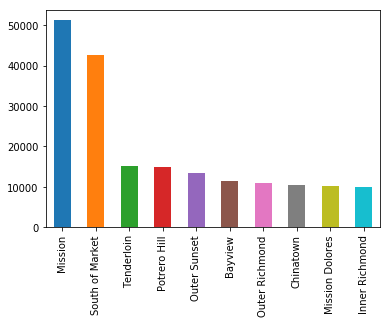

In [81]:
df['Neighborhood'].value_counts(ascending=False)[0:10].plot(kind='bar')

In [ ]:

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# Transferred cases
## which initial 'Responsible Agency' tend to transfer to other 'Responsible Agencies'?

Good question might be - can 311 better integrate its reporting with one or more Responsible Agencies?

In the next heatmap one can see transferred cases' originally designated Responsible Agencies (Y axis) and the Responsible Agencies they were ultimately transferred to (X axis). Therein, the darker the square at each intersection, the more often a transfer between those intersecting agencies took place, at least according to 311 records

In [ ]:
# only include the cases with Responsible_Agency = '311 Supervisor Queue'
df['invalid'] = df['Status Notes'].apply(lambda x: x.find('case') >= 0) & df['Status Notes'].apply(lambda x: x.find('invalid') >= 0) & (df['Responsible Agency'] == '311 Supervisor Queue')

# include the cases with any mention of 'transferred' in Status_Notes
df['transferred'] = df['Status Notes'].apply(lambda x: x.find('case') >= 0) & df['Status Notes'].apply(lambda x: x.find('transferred') >= 0) & (df['Responsible Agency'] == '311 Supervisor Queue')

df = df[~df['Status Notes'].apply(lambda x: x.find('dup') >= 0)]

In [ ]:

print('From {} to {}:'.format(df['Opened'].min(), df['Opened'].max()))
print('{:,} / {:,} cases are invalid ({:.1f}%)'.format(df['invalid'].sum(), df.shape[0], (df['invalid'].sum()/df.shape[0])*100))

In [ ]:
df[df['transferred']]['Category'].value_counts()

In [ ]:
print('From {} to {}:'.format(df['Opened'].min(), df['Opened'].max()))
print('For {}'.format('All Queues: '))
print('{:,} / {:,} cases are transferred ({:.1f}%)'.format(df['transferred'].sum(), df.shape[0], (df['transferred'].sum()/df.shape[0])*100))


In [ ]:
FEATURES_COLS = df.columns.tolist()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score
from catboost import CatBoostClassifier

cv = KFold(4, shuffle=True, random_state=2734)

for split_ix, (tridx, cvidx) in enumerate(cv.split(df)):
    model = CatBoostClassifier(iterations=500, depth=2, verbose=False)
    model.fit(df[FEATURES_COLS].iloc[tridx], tr_dataset['Survived'].iloc[tridx],
              eval_set=(tr_dataset[FEATURES_COLS].iloc[cvidx], tr_dataset['Survived'].iloc[cvidx]))

    tr_predictions = model.predict(tr_dataset[FEATURES_COLS].iloc[tridx])
    cv_predictions = model.predict(tr_dataset[FEATURES_COLS].iloc[cvidx])

    print("Fold %i" % split_ix)
    print("Training set accuracy:",
          accuracy_score(tr_dataset['Survived'].iloc[tridx], tr_predictions))
    print(classification_report(tr_dataset['Survived'].iloc[tridx], tr_predictions))
    
    print("Cross-validation set accuracy:",
          accuracy_score(tr_dataset['Survived'].iloc[cvidx], cv_predictions))
    print(classification_report(tr_dataset['Survived'].iloc[cvidx], cv_predictions))